# Harmonic comparison
Compare the results from the analytical harmonic trap with a real one

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as sc
from src.QTNMTraps import HarmonicTrap
from src.Particle import Particle
from src.RealFields import HarmonicField, BaseField
from scipy.optimize import minimize, brentq

In [28]:
# Allow LaTeX in figures
plt.rcParams['text.usetex'] = True

Plot a sample harmonic field and fit a quadratic function to it. This will allow us to extract some sample parameters.

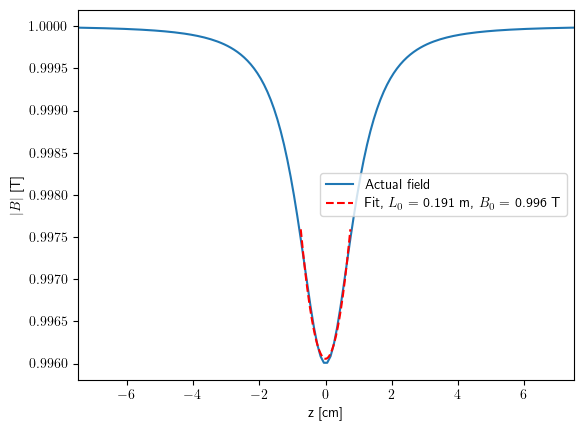

In [29]:
trapDepth = 4e-3  # Tesla
rCoil = 1.25e-2     # metres
iCoil = 2 * trapDepth * rCoil / sc.mu_0
bkgField = 1.0
hField = HarmonicField(rCoil, iCoil, bkgField)

zPlotArr = np.linspace(-0.1, 0.1, 200)
bPlotArr = hField.evaluate_field_magnitude(0.0, 0.0, zPlotArr)

# Create shorter range for fitting
modFitRange = 0.75e-2
z_data = np.linspace(-modFitRange, modFitRange, 100)
B_data = hField.evaluate_field_magnitude(0.0, 0.0, z_data)

def harmonic_form(z, params):
    """
    Function for harmonic form of trap

    Parameters
    ----------
    z
    """
    z = np.asarray(z)
    L0, B0 = params

    result = B0 * (1.0 + z**2 / L0**2)
    return result

def fit_harmonic_form(z_data, B_data, initial_params):
    z_min, z_max = np.min(z_data), np.max(z_data)

    def objective(params):
        L0, B0 = params

        if L0 <= 0.0:
            return 1e6
        if B0 <= 0.0:
            return 1e6

        B_pred = harmonic_form(z_data, params)
        return np.sum((B_data - B_pred)**2)

    result = minimize(objective, initial_params, method='Nelder-Mead',
                      options={'maxiter': 100000, 'xatol': 1e-8})
    
    if not result.success:
        print(f"Warning: Optimisation did not converge. Message: {result.message}")

    fitted_params = result.x
    z_fit = np.linspace(z_min, z_max, 1000)
    B_fit = harmonic_form(z_fit, fitted_params)
    return fitted_params, z_fit, B_fit

test_params = np.array([20e-2, bkgField - trapDepth])
fitted_params, z_fit, B_fit = fit_harmonic_form(z_data, B_data, test_params)
L0_fit = fitted_params[0]
B0_fit = fitted_params[1]

fig, ax = plt.subplots(1, 1)
ax.plot(zPlotArr * 1e2, bPlotArr, label='Actual field')
#ax.plot(z_fit * 1e2, harmonic_form(z_fit, test_params))
ax.plot(z_fit * 1e2, B_fit, 'r--', 
        label=fr'Fit, $L_0 =$ {L0_fit:.3f} m, $B_0 =$ {B0_fit:.3f} T')
ax.set_xlabel('z [cm]')
ax.set_ylabel(r'$|B|$ [T]')
ax.set_xlim(-7.5, 7.5)
ax.legend()

Compare the numerically calculated axial frequencies with those from an analytical trap with the same parameters.

In [30]:
def calc_zmax(trap: BaseField, particle: Particle):
    pa = particle.GetPitchAngle()
    centralField = trap.evaluate_field_magnitude(0., 0., 0.)
    muCentre = centralField / (np.sin(pa)**2)
    
    def zMaxEqn(z):
        result = 1.0 - muCentre / trap.evaluate_field_magnitude(0., 0., z)
        return result
    
    return brentq(zMaxEqn, 0.0, 1.0, full_output=False)

def calc_omega_axial_numerical(trap: BaseField, particle: Particle):
    pa = particle.GetPitchAngle()
    ke = particle.GetEnergy() * sc.e

    centralField = trap.evaluate_field_magnitude(0., 0., 0.)
    
    zMax = calc_zmax(trap, particle)

    # Equivalent magnetic moment
    muMag = ke * np.sin(pa)**2 / centralField

    # Calculate the integrand at each point
    integrationPoints = np.linspace(0, zMax, 2000, endpoint=False)
    integrand = 1.0 / np.sqrt((2 / sc.m_e) * (ke - muMag * trap.evaluate_field_magnitude(0., 0., integrationPoints)))

    integral = 2 * np.trapezoid(integrand, integrationPoints) / np.pi
    return 1 / integral, zMax

oa, zmax = calc_omega_axial_numerical(hField, Particle(18.6e3, np.zeros(3), 88.5 * np.pi / 180))
print(f"Axial frequency = {oa / (2 * np.pi) / 1e6:.1f} MHz, z_max = {zmax * 1e2:.1f} cm")


Axial frequency = 72.5 MHz, z_max = 0.5 cm


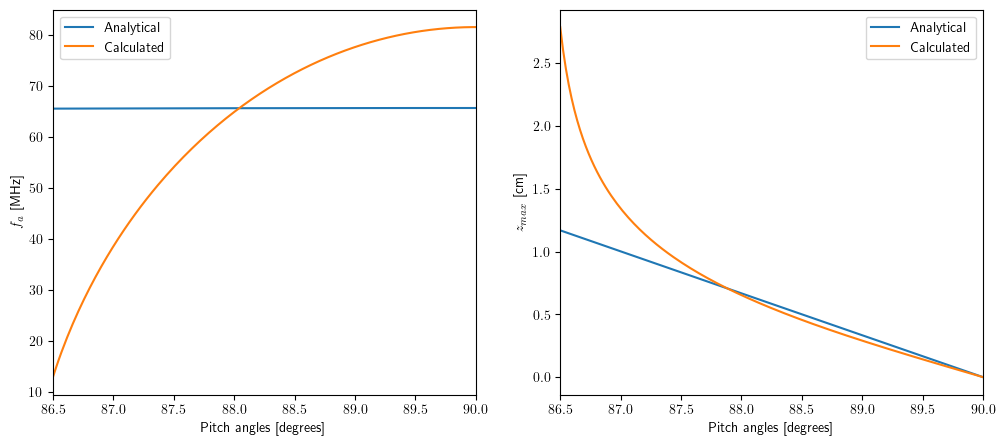

In [31]:
anaTrap = HarmonicTrap(B0_fit, L0_fit)
peArr = np.linspace(86.5, 89.999, 150) * np.pi / 180

axial_freqs_ana = anaTrap.CalcOmegaAxial(peArr, 0.263 * sc.c) / (2 * np.pi)
zmax_ana = anaTrap.CalcZMax(peArr)
axial_freqs_calc = np.zeros_like(peArr)
zmax_calc = np.zeros_like(peArr)

for i, p in enumerate(peArr):
    axial_freqs_calc[i], zmax_calc[i] = calc_omega_axial_numerical(hField, 
                                                                   Particle(18.6e3, np.zeros(3), p))
    
axial_freqs_calc /= (2 * np.pi)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(peArr * 180 / np.pi, axial_freqs_ana / 1e6, label='Analytical')
ax[0].plot(peArr * 180 / np.pi, axial_freqs_calc / 1e6, label='Calculated')
ax[0].set_xlabel('Pitch angles [degrees]')
ax[0].set_ylabel(r'$f_a$ [MHz]')
ax[0].set_xlim(86.5, 90)
ax[0].legend()

ax[1].plot(peArr * 180 / np.pi, zmax_ana * 1e2, label='Analytical')
ax[1].plot(peArr * 180 / np.pi, zmax_calc * 1e2, label='Calculated')
ax[1].set_xlabel('Pitch angles [degrees]')
ax[1].set_ylabel(r'$z_{max}$ [cm]')
ax[1].set_xlim(86.5, 90)
ax[1].legend()

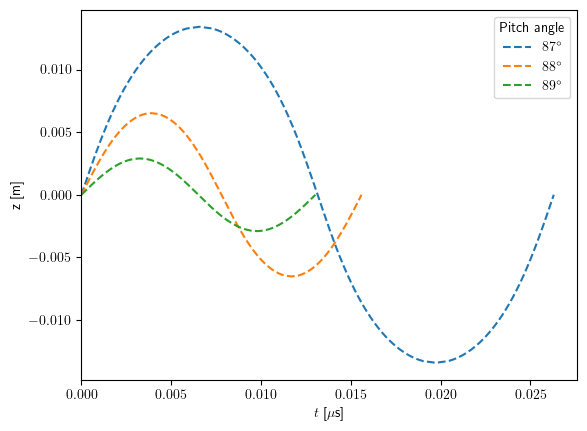

In [32]:
from scipy.integrate import cumulative_simpson

def calc_t_vs_z(trap: BaseField, particle: Particle, z_bin: float=1e-3):
    """
    Calculate the time versus the z position of an electron in a trap

    Parameters
    ----------
    trap : BathtubField

    particle : Particle

    z_bin : float
        z step to use in m
    """
    pa = particle.GetPitchAngle()
    ke = particle.GetEnergy() * sc.e
    centralField = trap.evaluate_field_magnitude(0., 0., 0.)

    zMax = calc_zmax(trap, particle)

    # Equivalent magnetic moment
    muMag = ke * np.sin(pa)**2 / centralField

    def t_integrand(z):
        result = np.sqrt(sc.m_e / 2) / np.sqrt(ke - muMag * trap.evaluate_field_magnitude(0, 0, z))
        return result
    
    zVals1 = np.linspace(0.0, 0.999 * zMax, 100)
    tVals1 = cumulative_simpson(t_integrand(zVals1), x=zVals1, initial=0.0)
    zVals2 = np.flip(zVals1[:-1])
    tVals2 = 2 * tVals1[-1] - np.flip(tVals1[:-1])
    tVals3 = tVals2[-1] + np.concatenate((tVals1[1:], tVals2))
    zVals3 = -np.concatenate((zVals1[1:], zVals2))
    tVals = np.concatenate((tVals1, tVals2, tVals3))
    zVals = np.concatenate((zVals1, zVals2, zVals3))
    return tVals, zVals 

pitchAngle = 88.0 * np.pi / 180
t87, z87 = calc_t_vs_z(hField, Particle(18.6e3, np.zeros(3), 87 * np.pi / 180))
t88, z88 = calc_t_vs_z(hField, Particle(18.6e3, np.zeros(3), pitchAngle))
t89, z89 = calc_t_vs_z(hField, Particle(18.6e3, np.zeros(3), 89 * np.pi / 180))

plt.figure()
plt.plot(t87 * 1e6, z87, '--', label=r'$87^\circ$')
plt.plot(t88 * 1e6, z88, '--', label=r'$88^\circ$')
plt.plot(t89 * 1e6, z89, '--', label=r'$89^\circ$')
plt.xlabel(r"$t$ [$\mu$s]")
plt.ylabel(r"z [m]")
plt.legend(title='Pitch angle')
plt.xlim(0.0, None)
plt.show()

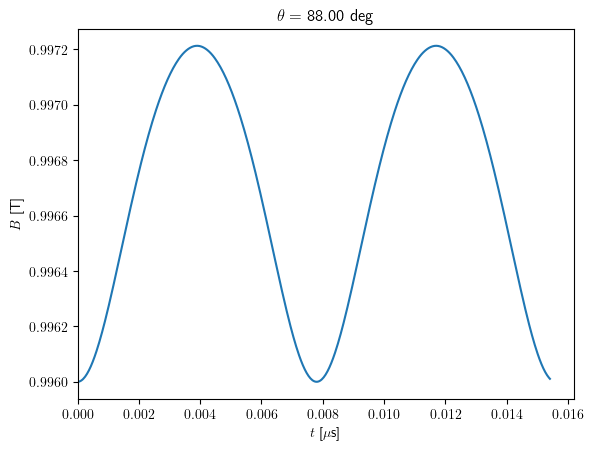

In [33]:
from scipy.interpolate import interp1d

pitchAngle = 88 * np.pi / 180
p1 = Particle(18.6e3, np.zeros(3), pitchAngle)

def B_from_t(trap: BaseField, part: Particle, t_vals):
    t, z = calc_t_vs_z(trap, part)
    t_to_z = interp1d(t, z, kind='cubic')
    z = t_to_z(t_vals)
    return hField.evaluate_field_magnitude(0, 0, z)

# Calculate the period of the axial motion
oa, _ = calc_omega_axial_numerical(hField, p1)
Ta = 1.0 / (oa / (2 * np.pi))

t_vals = np.linspace(0.0, Ta, 500)

B = B_from_t(hField, p1, t_vals)
plt.figure()
plt.plot(t_vals * 1e6, B)
plt.xlabel(r"$t$ [$\mu$s]")
plt.ylabel(r"$B$ [T]")
plt.title(fr"$\theta =$ {pitchAngle * 180 / np.pi:.2f} deg")
plt.xlim(0.0, None)
plt.show()

Text(0, 0.5, '$\\Phi_c - \\Omega_0 t$ [radians]')

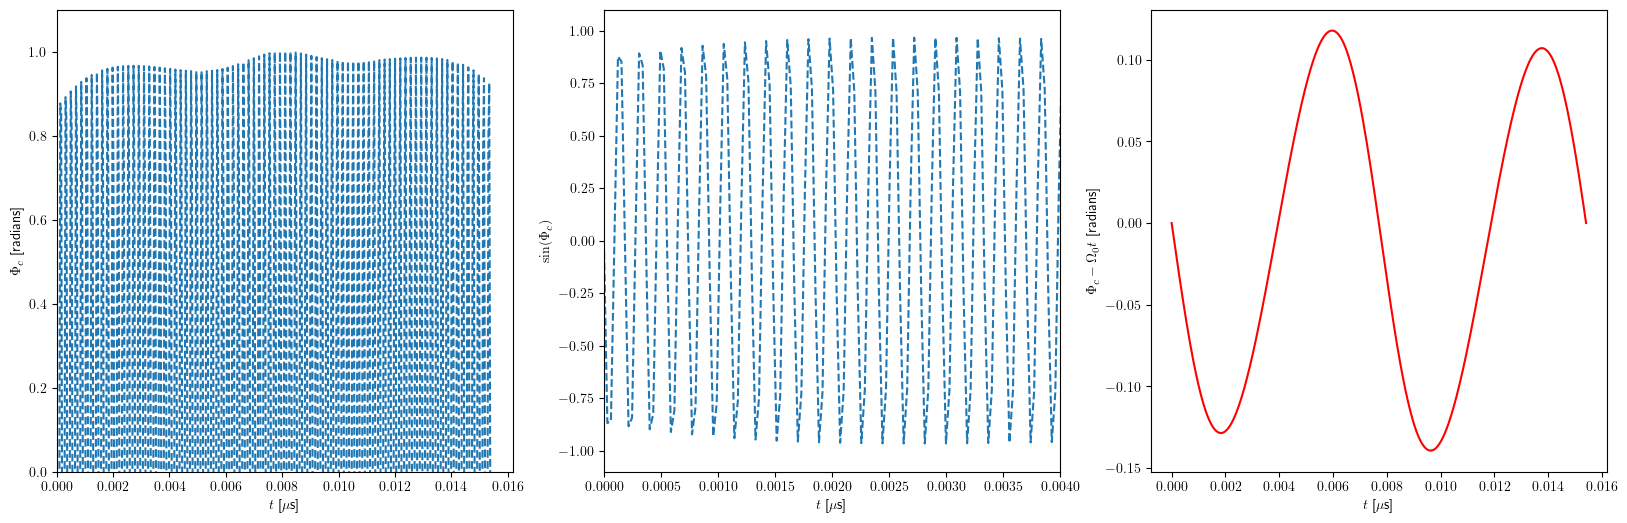

In [34]:
from scipy.integrate import simpson

def cyclotron_phase_from_t(trap: BaseField, particle: Particle, t_vals):
    B = B_from_t(trap, particle, t_vals)
    return cumulative_simpson(sc.e * B / (particle.GetGamma() * sc.m_e), x=t_vals, initial=0.0)

def calc_omega_0(trap: BaseField, particle: Particle, t_vals):
    phi_Ta = simpson(sc.e * B_from_t(trap, particle, t_vals) / (particle.GetGamma() * sc.m_e), t_vals)
    return phi_Ta / t_vals[-1]

t_vals = np.linspace(0, Ta, 499)
phiTest = cyclotron_phase_from_t(hField, p1, t_vals)
fig, ax = plt.subplots(1, 3, figsize=(20, 6))
ax[0].plot(t_vals * 1e6, np.sin(phiTest), '--')
ax[0].set_xlabel(r"$t$ [$\mu$s]")
ax[0].set_ylabel(r"$\Phi_c$ [radians]")
ax[0].set_xlim(0, None)
ax[0].set_ylim(0, None)

ax[1].plot(t_vals * 1e6, np.sin(phiTest), '--')
ax[1].set_xlabel(r"$t$ [$\mu$s]")
ax[1].set_ylabel(r"$\sin(\Phi_c)$")
ax[1].set_xlim(0, 0.004)

ax[2].plot(t_vals * 1e6, phiTest - calc_omega_0(hField, p1, t_vals) * t_vals, 'r-')
ax[2].set_xlabel(r"$t$ [$\mu$s]")
ax[2].set_ylabel(r"$\Phi_c - \Omega_0 t$ [radians]")

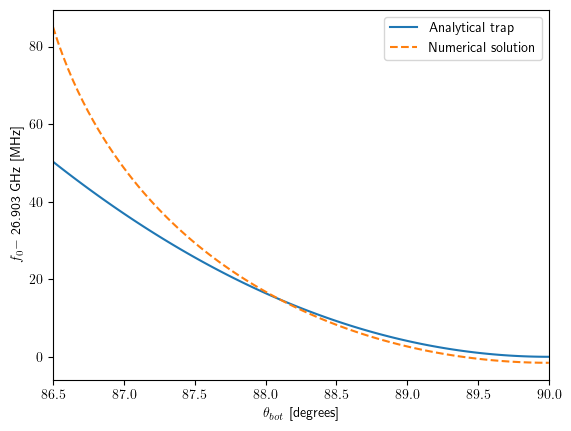

In [35]:
testNumericalPitches = np.linspace(86.5, 89.999, 100) * np.pi / 180
avgFreqsNumerical = np.zeros_like(testNumericalPitches)
for i, testPitch in enumerate(testNumericalPitches):
    testParticle = Particle(18.6e3, np.zeros(3), testPitch)
    # Calculate the axial frequency for the time binning
    oa, _ = calc_omega_axial_numerical(hField, testParticle)
    Ta = 1.0 / (oa / (2 * np.pi))
    tVals = np.linspace(0, Ta, 500)

    avgFreqsNumerical[i] = calc_omega_0(hField, testParticle, tVals) / (2 * np.pi)

avgFreqArray = anaTrap.CalcOmega0(Particle(18.6e3, np.zeros(3)).GetSpeed(), 
                                  testNumericalPitches) / (2 * np.pi)

plt.figure()
plt.plot(testNumericalPitches * 180 / np.pi, (avgFreqArray - np.min(avgFreqArray)) / 1e6, label='Analytical trap')
plt.plot(testNumericalPitches * 180 / np.pi, (avgFreqsNumerical - np.min(avgFreqArray)) / 1e6, 
         '--', label='Numerical solution')
plt.xlabel(r"$\theta_{bot}$ [degrees]")
plt.ylabel(fr"$f_0 -$ {np.min(avgFreqArray) / 1e9:.3f} GHz [MHz]")
plt.xlim(86.5, 90)
plt.legend()
plt.show()

In [36]:
from src.PowerSpectrumCalculator import PowerSpectrumCalculator
from src.CircularWaveguide import CircularWaveguide

rWg = 5e-3  # 5mm radius waveguide
wg = CircularWaveguide(rWg)

pspecAna = PowerSpectrumCalculator(anaTrap, wg, p1)
n1 = pspecAna.GetPeakAmp(0)
print(n1)

(np.float64(-0.2046920817081697), np.float64(-0.2046920817081697))


In [37]:
def get_fourier_coeff(trap: BaseField, particle: Particle, n: int):
    """
    Calculate the Fourier coefficient for a given order 

    Parameters
    ----------
    trap : BathtubField
      Trapping field
    particle : Particle
      Particle to be propagated
    n : int
      Order of sideband

    Returns
    -------
    complex :
      Complex fourier coefficient
    """
    omega_a, _ = calc_omega_axial_numerical(trap, particle)

    # Get z position at regularly spaced intervals
    t, z = calc_t_vs_z(trap, particle)
    interp_t_z = interp1d(t, z, kind='cubic')

    Ta =  t[-1]
    tVals = np.linspace(0, Ta, 500)

    z_t = interp_t_z(tVals)
    omega_0 = calc_omega_0(trap, particle, tVals)
    phi_t = cyclotron_phase_from_t(trap, particle, tVals)

    omega_c = 1.841 * sc.c / 5e-3
    v_phase = sc.c / np.sqrt(1 - (omega_c / omega_0)**2)
    kLambda = omega_0 / v_phase

    integrand = np.exp(1j * (phi_t + kLambda * z_t)) * np.exp(-1j * (omega_0 + n * omega_a) * tVals) 
    #integrand = np.exp(1j * (phi_t)) * np.exp(-1j * (omega_0 + n * omega_a)) 
    a_n = simpson(integrand, tVals)
    a_n /= Ta

    return a_n

In [38]:
print(get_fourier_coeff(hField, Particle(18.6e3, np.zeros(3), 89.999*np.pi/180.0), 0))

(0.9999996430706732+2.2292287321451323e-12j)


Compare the analytic harmonic trap to the real deal

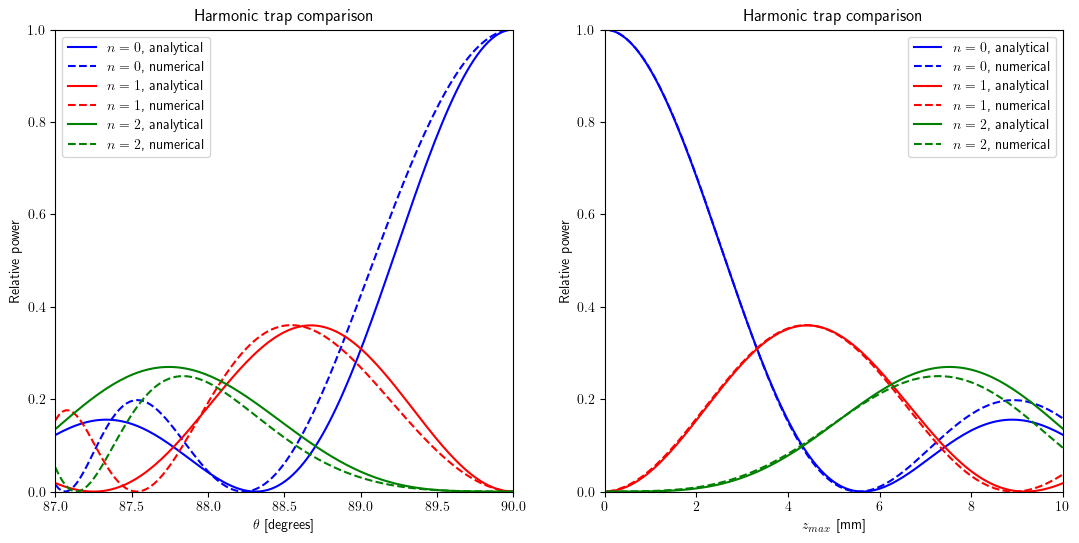

In [45]:
pitchAngleCoarse = np.linspace(87.0, 89.999, 130) * np.pi / 180
zmax_ana = np.zeros_like(pitchAngleCoarse)
zmax_num = np.zeros_like(pitchAngleCoarse)
a0_mainband_ana = np.zeros_like(pitchAngleCoarse, dtype=complex)
a0_mainband_num = np.zeros_like(pitchAngleCoarse, dtype=complex)
a1_mainband_ana = np.zeros_like(pitchAngleCoarse, dtype=complex)
a1_mainband_num = np.zeros_like(pitchAngleCoarse, dtype=complex)
a2_mainband_ana = np.zeros_like(pitchAngleCoarse, dtype=complex)
a2_mainband_num = np.zeros_like(pitchAngleCoarse, dtype=complex)

for i, p in enumerate(pitchAngleCoarse):
    thisParticle = Particle(18.6e3, np.zeros(3), p)
    zmax_ana[i] = anaTrap.CalcZMax(p)
    zmax_num[i] = calc_zmax(hField, thisParticle)

    a0_mainband_ana[i], _ = PowerSpectrumCalculator(anaTrap, wg, 
                                                    thisParticle).GetPeakAmp(0)
    a0_mainband_num[i] = get_fourier_coeff(hField, thisParticle, 0)
    a1_mainband_ana[i], _ = PowerSpectrumCalculator(anaTrap, wg, 
                                                    thisParticle).GetPeakAmp(1)
    a1_mainband_num[i] = get_fourier_coeff(hField, thisParticle, 1)
    a2_mainband_ana[i], _ = PowerSpectrumCalculator(anaTrap, wg, 
                                                    thisParticle).GetPeakAmp(2)
    a2_mainband_num[i] = get_fourier_coeff(hField, thisParticle, 2)

fig, ax = plt.subplots(1, 2, figsize=(13, 6))
ax[0].plot(pitchAngleCoarse * 180 / np.pi, np.abs(a0_mainband_ana)**2, 'b-', 
        label=r'$n=0$, analytical')
ax[0].plot(pitchAngleCoarse * 180 / np.pi, np.abs(a0_mainband_num)**2, 'b--', 
        label=r'$n=0$, numerical')
ax[0].plot(pitchAngleCoarse * 180 / np.pi, np.abs(a1_mainband_ana)**2, 'r-', 
        label=r'$n=1$, analytical')
ax[0].plot(pitchAngleCoarse * 180 / np.pi, np.abs(a1_mainband_num)**2, 'r--', 
        label=r'$n=1$, numerical')
ax[0].plot(pitchAngleCoarse * 180 / np.pi, np.abs(a2_mainband_ana)**2, 'g-', 
        label=r'$n=2$, analytical')
ax[0].plot(pitchAngleCoarse * 180 / np.pi, np.abs(a2_mainband_num)**2, 'g--', 
        label=r'$n=2$, numerical')
ax[0].set_xlabel(r"$\theta$ [degrees]")
ax[0].set_ylabel("Relative power")
ax[0].set_title("Harmonic trap comparison")
ax[0].set_xlim(np.min(pitchAngleCoarse) * 180 / np.pi, 90.0)
ax[0].set_ylim(0, 1)
ax[0].legend()

ax[1].plot(zmax_ana * 1e3, np.abs(a0_mainband_ana)**2, 'b-', label=r'$n=0$, analytical')
ax[1].plot(zmax_num * 1e3, np.abs(a0_mainband_num)**2, 'b--', label=r'$n=0$, numerical')
ax[1].plot(zmax_ana * 1e3, np.abs(a1_mainband_ana)**2, 'r-', label=r'$n=1$, analytical')
ax[1].plot(zmax_num * 1e3, np.abs(a1_mainband_num)**2, 'r--', label=r'$n=1$, numerical')
ax[1].plot(zmax_ana * 1e3, np.abs(a2_mainband_ana)**2, 'g-', label=r'$n=2$, analytical')
ax[1].plot(zmax_num * 1e3, np.abs(a2_mainband_num)**2, 'g--', label=r'$n=2$, numerical')
ax[1].set_xlabel(r"$z_{max}$ [mm]")
ax[1].set_ylabel("Relative power")
ax[1].set_title("Harmonic trap comparison")
ax[1].set_xlim(0.0, 10.0)
ax[1].set_ylim(0, 1)
ax[1].legend()